Simple ConvBiLSTM and ConvBiGRU

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5297 - mae: 0.5190
Epoch 1: val_loss improved from inf to 0.12855, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.5249 - mae: 0.5163 - val_loss: 0.1286 - val_mae: 0.2589
Epoch 2/30
43/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1501 - mae: 0.2890
Epoch 2: val_loss improved from 0.12855 to 0.12500, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1508 - mae: 0.2895 - val_loss: 0.1250 - val_mae: 0.2676
Epoch 3/30
43/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1517 - mae: 0.2962
Epoch 3: val_loss improved from 0.12500 to 0.11935, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1513 - mae: 0.2957 - val_loss: 0.1193 - val_mae: 0.2538
Epoch 4/30
43/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1331 - mae: 0.2751
Epoch 4: val_loss did not improve from 0.11935
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1340 - mae: 0.2

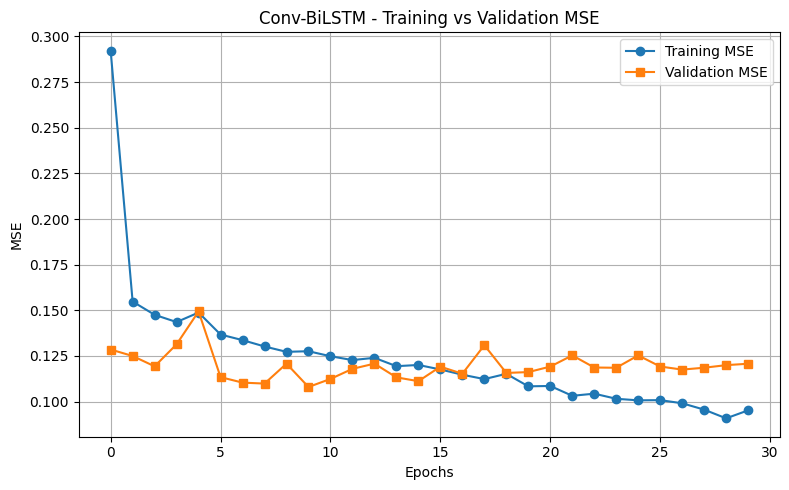

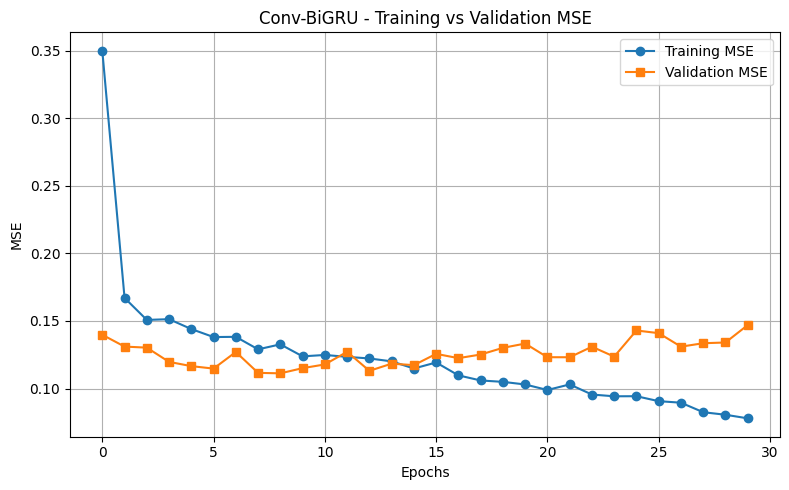

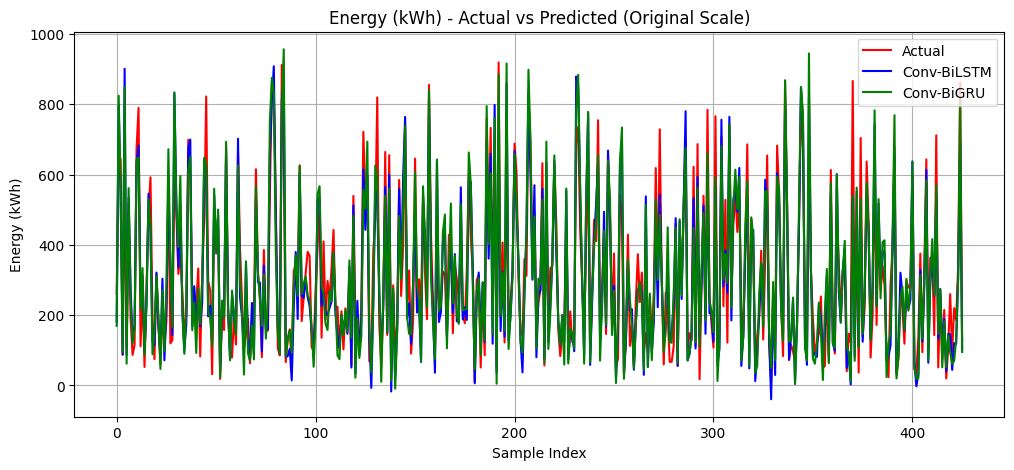

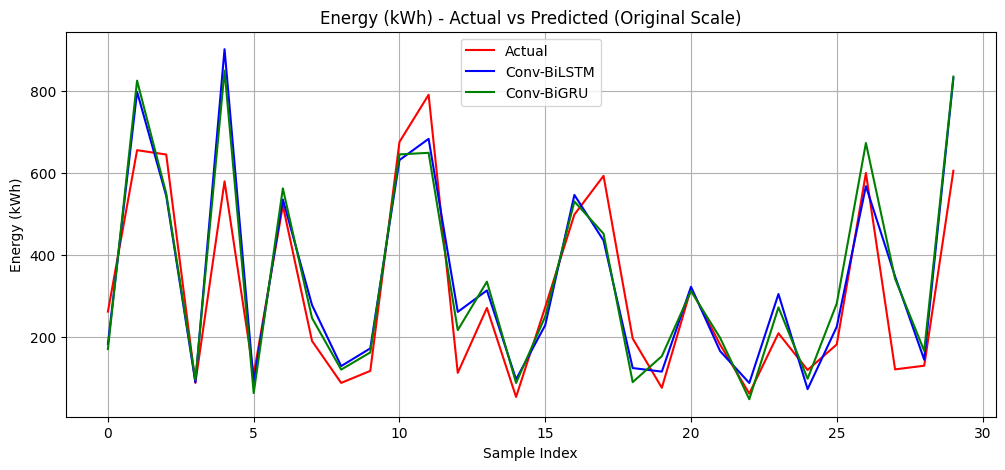

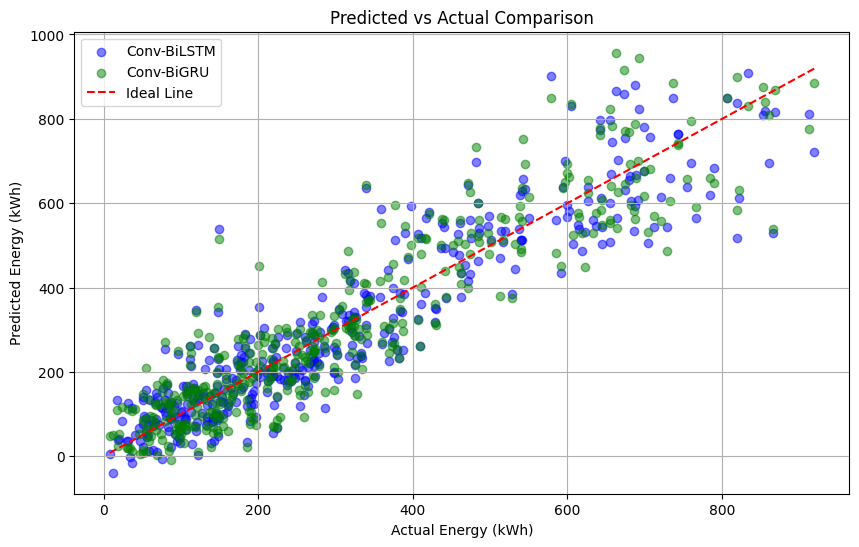

In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
from math import sqrt

# Load dataset
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

# Define columns
categorical_cols = ['Station_Name', 'Address', 'Zip_Postal_Code', 'Start_Hour', 'End_Hour', 'Day_of_Week', 'is_weekend', 'season']
numerical_cols = ['Total_Duration_hours', 'Charging_Time_hours']
target_col = 'Energy__kWh_'

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Apply StandardScaler to numerical columns + target
scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Split into X and y
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values

# Sequence creation
def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)

# Train-test split
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Embedding configuration
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# Build model
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare model input
def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Conv-BiLSTM
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Conv-BiGRU
model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                validation_split=0.1,callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru = model_bigru.predict(test_inputs).flatten()

# Inverse transform predictions to original scale
def inverse_transform(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    return scaler.inverse_transform(combined)[:, -1]

y_test_orig = inverse_transform(y_test)
y_pred_bilstm_orig = inverse_transform(y_pred_bilstm)
y_pred_bigru_orig = inverse_transform(y_pred_bigru)

# Evaluation Function
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

    print(f"\n{name} Performance (Original Scale):")
    print(f"  MSE : {mean_squared_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  MAE : {mean_absolute_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_test_orig, inverse_transform(y_pred))):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test_orig, inverse_transform(y_pred)) * 100:.6f}")
    print(f"  R²  : {r2_score(y_test_orig, inverse_transform(y_pred)):.6f}")

evaluate_model(y_test, y_pred_bilstm, "Conv-BiLSTM")
evaluate_model(y_test, y_pred_bigru, "Conv-BiGRU")

# Visualization
def plot_training_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title("Energy (kWh) - Actual vs Predicted (Original Scale)")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curve(history_bilstm, "Conv-BiLSTM")
plot_training_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, 1000, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters


Epoch 1/50
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3695 - mae: 0.4246
Epoch 1: val_loss improved from inf to 0.06021, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.3585 - mae: 0.4174 - val_loss: 0.0602 - val_mae: 0.1905
Epoch 2/50
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0978 - mae: 0.2405
Epoch 2: val_loss did not improve from 0.06021
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0978 - mae: 0.2402 - val_loss: 0.0607 - val_mae: 0.1909
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0889 - mae: 0.2280
Epoch 3: val_loss improved from 0.06021 to 0.05929, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0889 - mae: 0.2279 - val_loss: 0.0593 - val_mae: 0.1941
Epoch 4/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0894 - mae: 0.2270
Epoch 4: val_loss improved from 0.05929 to 0.05479, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0893 - mae

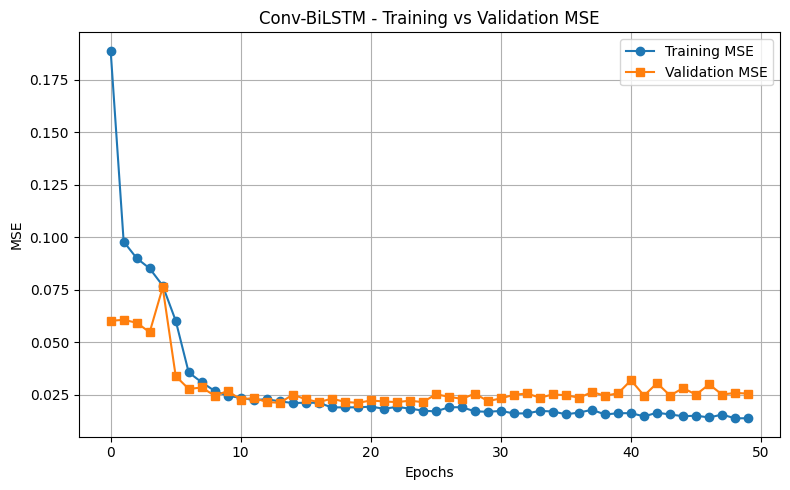

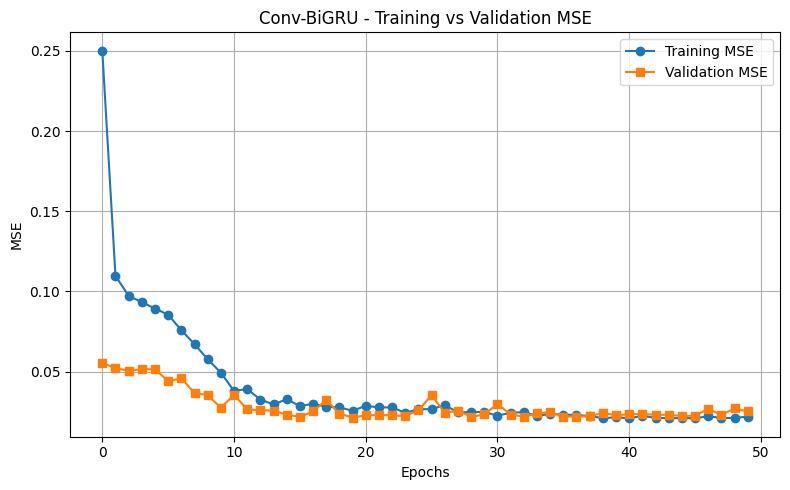

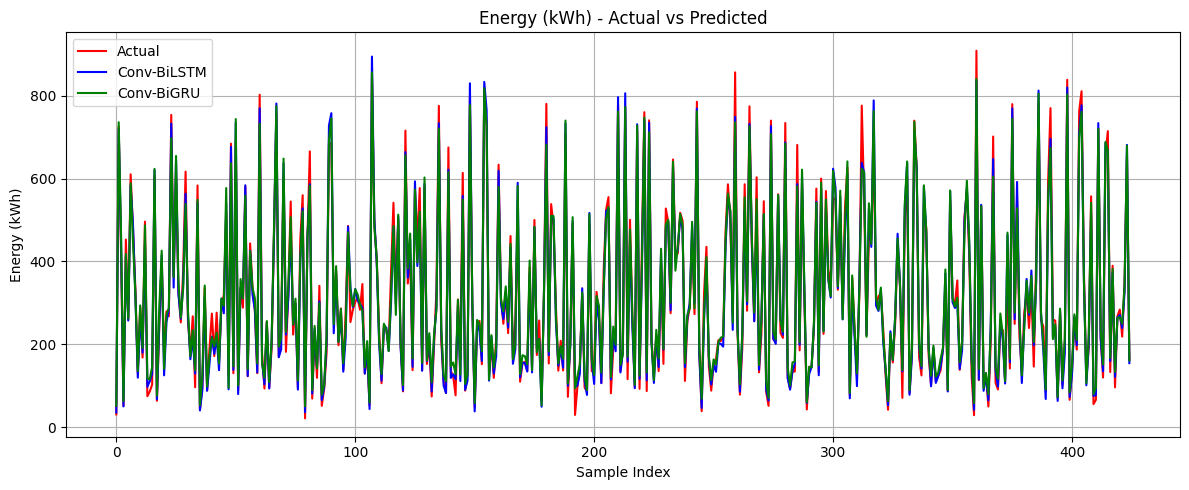

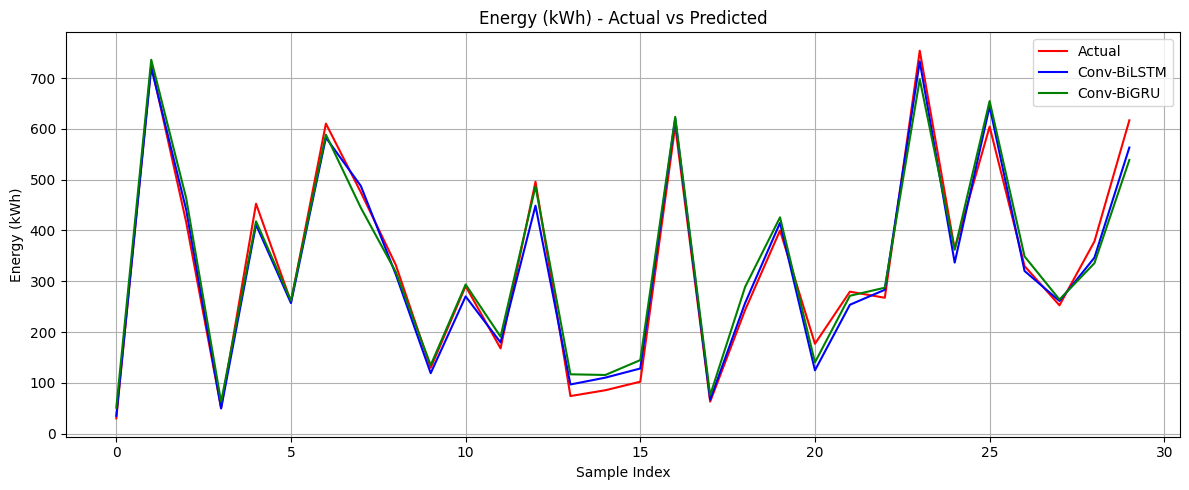

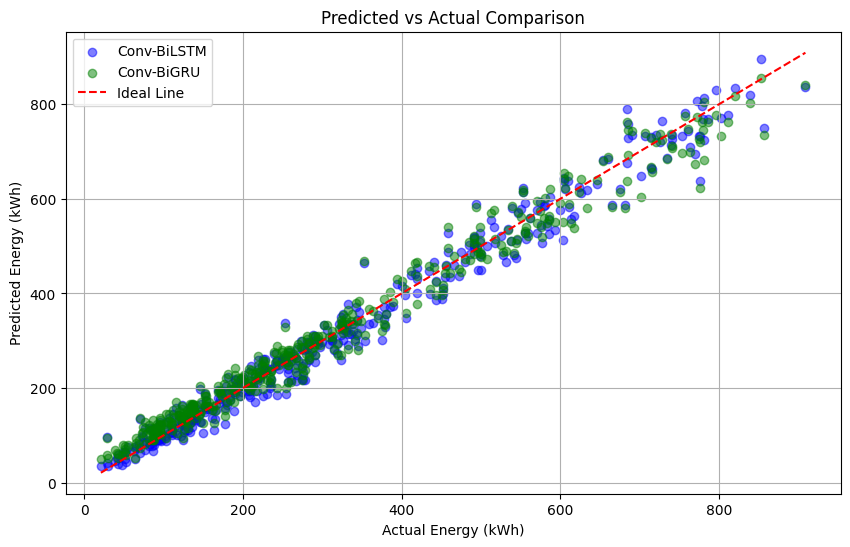

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os

# ✅ Load updated dataset
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

# ✅ Updated preprocessing WITHOUT log
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy__kWh_'].shift(lag)
df['rolling_mean_3'] = df['Energy__kWh_'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy__kWh_'].rolling(window=3).std()
df['smooth_target'] = df['Energy__kWh_'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# ✅ Updated columns
categorical_cols = ['Station_Name', 'Address', 'Zip_Postal_Code', 'Start_Hour', 'End_Hour', 'Day_of_Week', 'is_weekend', 'season']
numerical_cols = ['Total_Duration_hours', 'Charging_Time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# ✅ Updated scaling
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# ✅ Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model_bilstm = build_model('lstm')
model_bigru = build_model('gru')

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters and GA for time steps selection

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


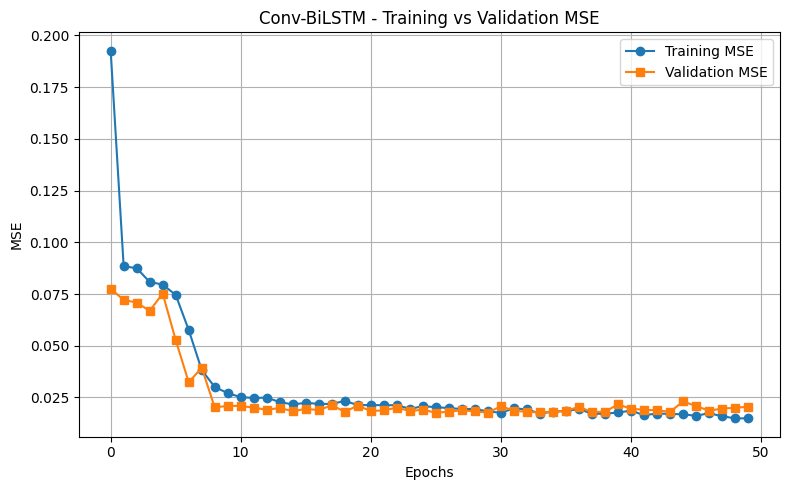

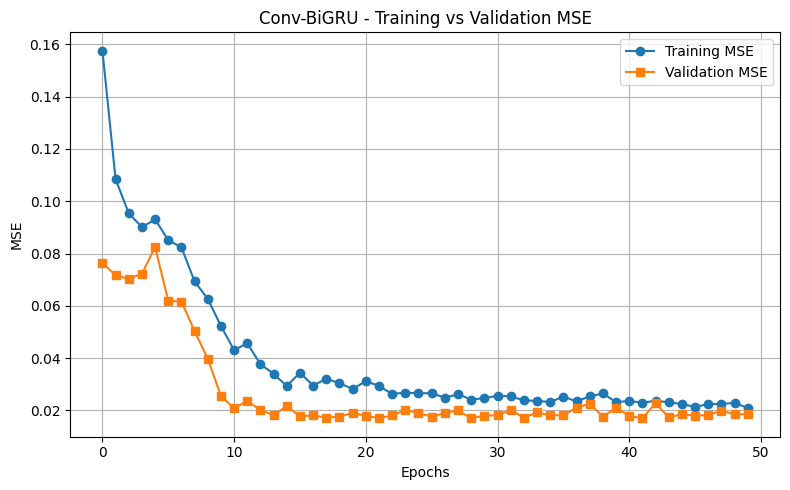

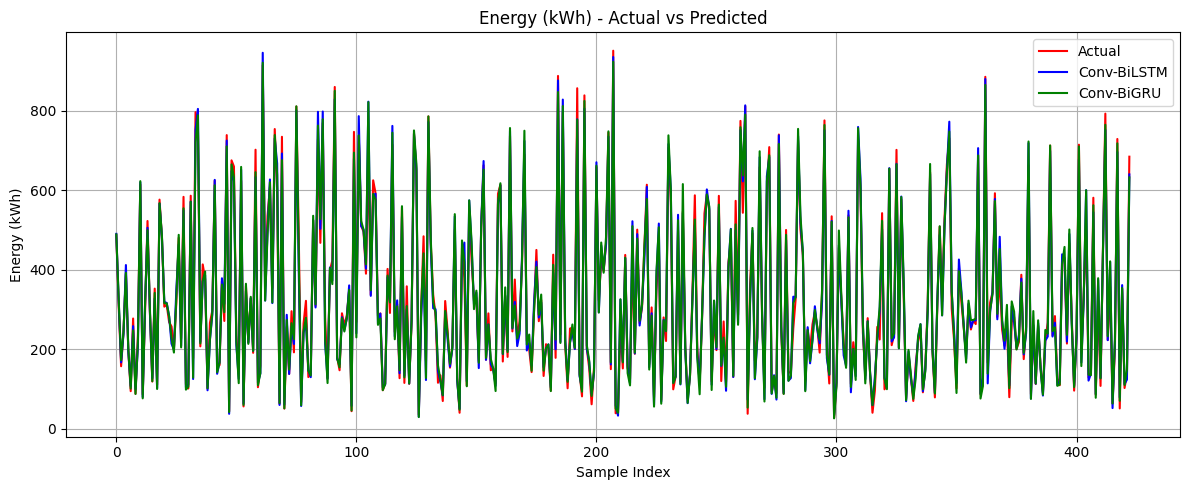

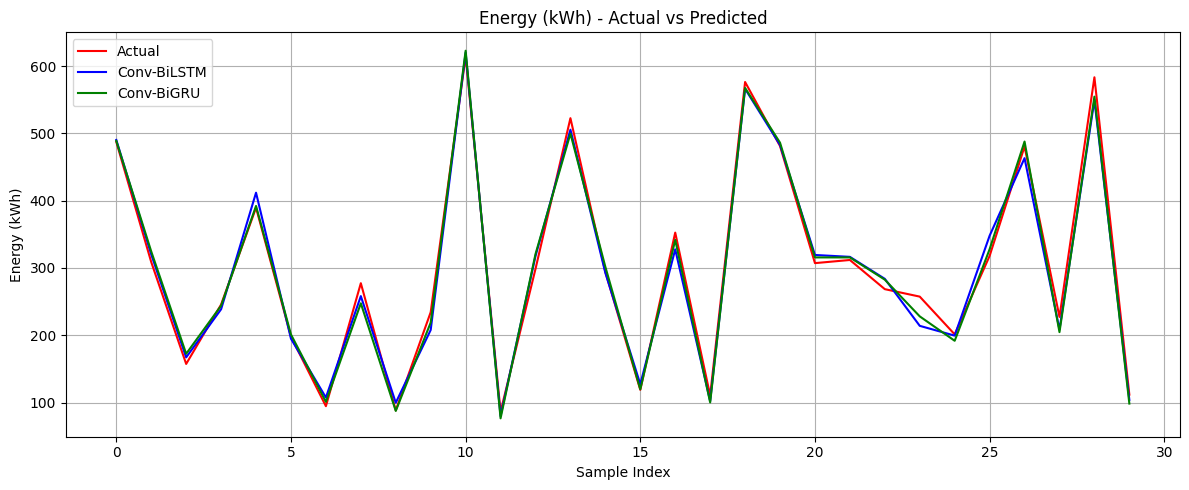

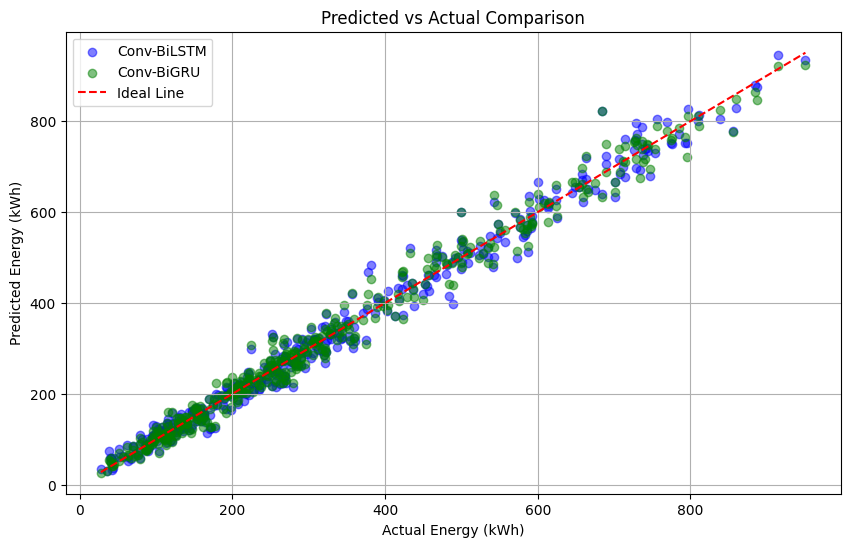

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os
import pygad

# ✅ Load dataset
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

# ✅ Preprocessing WITHOUT log
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy__kWh_'].shift(lag)
df['rolling_mean_3'] = df['Energy__kWh_'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy__kWh_'].rolling(window=3).std()
df['smooth_target'] = df['Energy__kWh_'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

categorical_cols = ['Station_Name', 'Address', 'Zip_Postal_Code', 'Start_Hour', 'End_Hour', 'Day_of_Week', 'is_weekend', 'season']
numerical_cols = ['Total_Duration_hours', 'Charging_Time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

X_cat_full = df[categorical_cols].values
X_num_full = df[numerical_cols].values
y_full = df['target_scaled'].values

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type, time_steps):
    cat_inputs = [Input(shape=(time_steps,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(time_steps, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def create_sequences(X_cat, X_num, y, time_steps):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

# ✅ Fitness function for GA
def fitness_func(ga_instance, solution, solution_idx):
    time_steps = int(solution[0])
    X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat_full, X_num_full, y_full, time_steps)
    X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)
    train_inputs = prepare_input(X_cat_train, X_num_train)
    test_inputs = prepare_input(X_cat_test, X_num_test)

    model_bilstm = build_model('lstm', time_steps)
    model_bigru = build_model('gru', time_steps)

    model_bilstm.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    model_bigru.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
    y_pred_bigru = model_bigru.predict(test_inputs).flatten()

    mse_bilstm = mean_squared_error(y_test, y_pred_bilstm)
    mse_bigru = mean_squared_error(y_test, y_pred_bigru)
    avg_mse = (mse_bilstm + mse_bigru) / 2

    return -avg_mse  # negative because GA maximizes

# ✅ PyGAD setup
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=1,
    gene_type=int,
    init_range_low=7,
    init_range_high=90,
    gene_space={'low': 7, 'high': 90, 'step': 1},
    mutation_percent_genes=100,
    mutation_type="random"
)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_time_step = int(solution[0])
print(f"\n✅ Best time_steps found: {best_time_step} with fitness {solution_fitness:.6f}")

# ✅ Final training with best time_steps
X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat_full, X_num_full, y_full, best_time_step)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

model_bilstm = build_model('lstm', best_time_step)
model_bigru = build_model('gru', best_time_step)

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Peak Day Prediction using 7 day forecast

Epoch 1/95
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5413
Epoch 1: val_loss improved from inf to 0.10006, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5303 - val_loss: 0.1001
Epoch 2/95
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1011
Epoch 2: val_loss improved from 0.10006 to 0.09125, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1011 - val_loss: 0.0912
Epoch 3/95
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0918
Epoch 3: val_loss improved from 0.09125 to 0.08811, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0918 - val_loss: 0.0881
Epoch 4/95
42/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0819
Epoch 4: val_loss improved from 0.08811 to 0.08393, saving model to temp_bilstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0826 - val_loss: 0.0839
Epoch 5/95
40/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0830
Epoch 5: val_loss improved from 0.08393 t

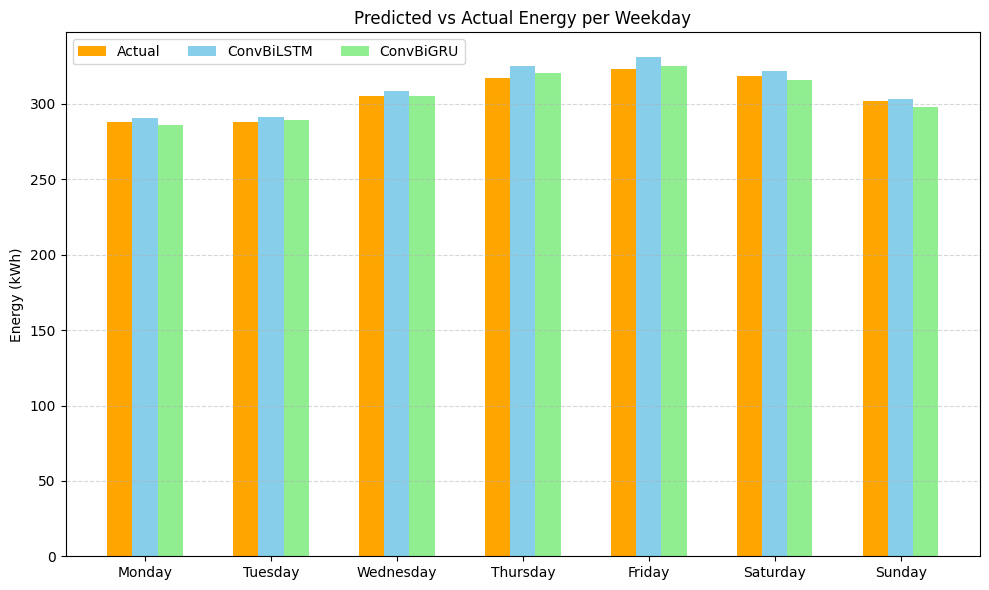

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
import os

# Load dataset
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy__kWh_'].shift(lag)
df['rolling_mean_3'] = df['Energy__kWh_'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy__kWh_'].rolling(window=3).std()
df['smooth_target'] = df['Energy__kWh_'].rolling(window=3, min_periods=1).mean()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['Station_Name', 'Address', 'Zip_Postal_Code', 'Start_Hour', 'End_Hour', 'Day_of_Week', 'is_weekend', 'season']
numerical_cols = ['Total_Duration_hours', 'Charging_Time_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']
target_col = 'smooth_target'

# Encode and scale
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Sequence data
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values
dow = df['Day_of_Week'].values

def create_7day_sequences(X_cat, X_num, y, dow, time_steps=20):
    Xs_cat, Xs_num, ys, dows = [], [], [], []
    for i in range(len(X_cat) - time_steps - 7):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps:i + time_steps + 7])
        dows.append(dow[i + time_steps:i + time_steps + 7])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys), np.array(dows)

X_cat_seq, X_num_seq, y_seq, dow_seq = create_7day_sequences(X_cat, X_num, y, dow)

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, dow_train, dow_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, dow_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(20,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(20, len(numerical_cols)), name="numerical_input")
    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)
    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(7)(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Train Conv-BiLSTM
model_bilstm = build_model('lstm')
model_bilstm.fit(train_inputs, y_train, epochs=95, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Train Conv-BiGRU
model_bigru = build_model('gru')
model_bigru.fit(train_inputs, y_train, epochs=95, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm_scaled = model_bilstm.predict(test_inputs)
y_pred_bigru_scaled = model_bigru.predict(test_inputs)

# Inverse transform predictions
def inverse_transform_7day(predictions):
    restored = []
    for i in range(predictions.shape[1]):
        pad = np.zeros((len(predictions), len(numerical_cols)))
        combined = np.hstack((pad, predictions[:, i:i+1]))
        restored_kwh = scaler.inverse_transform(combined)[:, -1]
        restored.append(restored_kwh)
    return np.stack(restored, axis=1)

y_pred_bilstm_kwh = inverse_transform_7day(y_pred_bilstm_scaled)
y_pred_bigru_kwh = inverse_transform_7day(y_pred_bigru_scaled)

# Aggregate predicted energy by weekday
weekday_energy_bilstm = {i: [] for i in range(7)}
weekday_energy_bigru = {i: [] for i in range(7)}

for i in range(len(dow_test)):
    for d, e1, e2 in zip(dow_test[i], y_pred_bilstm_kwh[i], y_pred_bigru_kwh[i]):
        weekday_energy_bilstm[d].append(e1)
        weekday_energy_bigru[d].append(e2)

# Calculate average and total energy
avg_kwh_bilstm = {d: np.mean(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
avg_kwh_bigru = {d: np.mean(weekday_energy_bigru[d]) for d in weekday_energy_bigru}
total_kwh_bilstm = {d: np.sum(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
total_kwh_bigru = {d: np.sum(weekday_energy_bigru[d]) for d in weekday_energy_bigru}

# Calculate actual average energy per weekday (from the original dataset)
def inverse_transform_actual(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    restored_kwh = scaler.inverse_transform(combined)[:, -1]
    return restored_kwh

df['Actual_Energy'] = inverse_transform_actual(df[target_col].values)

# Now, calculate the average energy per weekday
actual_avg_kwh = {i: np.mean(df[df['Day_of_Week'] == i]['Actual_Energy']) for i in range(7)}

# Create readable DataFrame with actual values
df_summary = pd.DataFrame({
    'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'Avg_kWh_BiLSTM': [avg_kwh_bilstm[i] for i in range(7)],
    'Avg_kWh_BiGRU': [avg_kwh_bigru[i] for i in range(7)],
    'Actual_Avg_kWh': [actual_avg_kwh[i] for i in range(7)],
    'Total_kWh_BiLSTM': [total_kwh_bilstm[i] for i in range(7)],
    'Total_kWh_BiGRU': [total_kwh_bigru[i] for i in range(7)]
    
})

print("\n📋 Predicted and Actual Energy Summary per Weekday:")
print(df_summary)

# Optional: plot side-by-side average with actual energy values
plt.figure(figsize=(10, 6))
x = np.arange(7)
bar_width = 0.2
plt.bar(x - bar_width, df_summary['Actual_Avg_kWh'], width=bar_width, label='Actual', color='orange')
plt.bar(x, df_summary['Avg_kWh_BiLSTM'], width=bar_width, label='ConvBiLSTM', color='skyblue')
plt.bar(x + bar_width, df_summary['Avg_kWh_BiGRU'], width=bar_width, label='ConvBiGRU', color='lightgreen')
plt.xticks(x, df_summary['Weekday'])
plt.ylabel("Energy (kWh)")
plt.title("Predicted vs Actual Energy per Weekday")
plt.legend(loc='upper left', ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


ConvLSTM-BiLSTM

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 3.4431 - mae: 0.6664 - val_loss: 1.5715 - val_mae: 0.3468
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.3406 - mae: 0.3378 - val_loss: 0.8009 - val_mae: 0.3135
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.7309 - mae: 0.3124 - val_loss: 0.5228 - val_mae: 0.2964
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4983 - mae: 0.2963 - val_loss: 0.4131 - val_mae: 0.2927
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.4052 - mae: 0.2907 - val_loss: 0.3598 - val_mae: 0.2930
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.3465 - mae: 0.2827 - val_loss: 0.3175 - val_mae: 0.2923
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.3196 - mae: 0.2914 - val_loss: 0.2931 - val_mae: 0.2984
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.2961 - mae: 0.2934 - val_loss: 0.2660 - val_mae: 0.2884
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.275

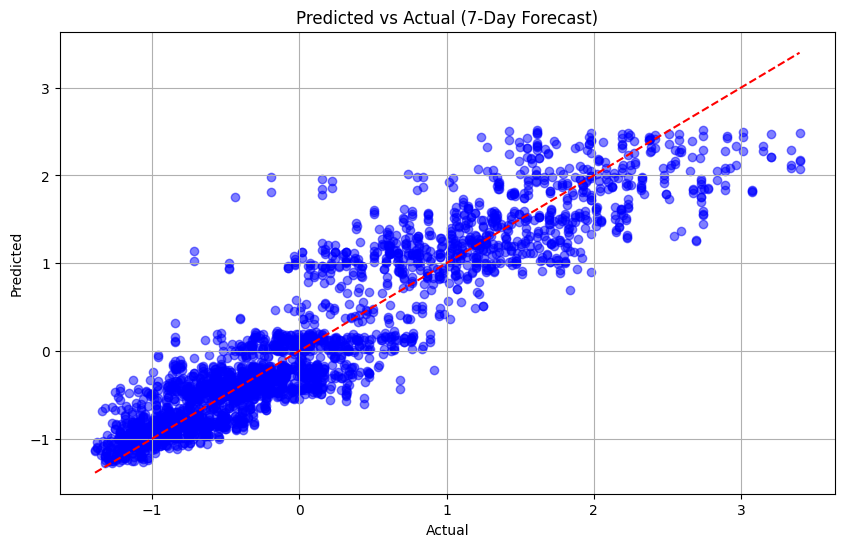

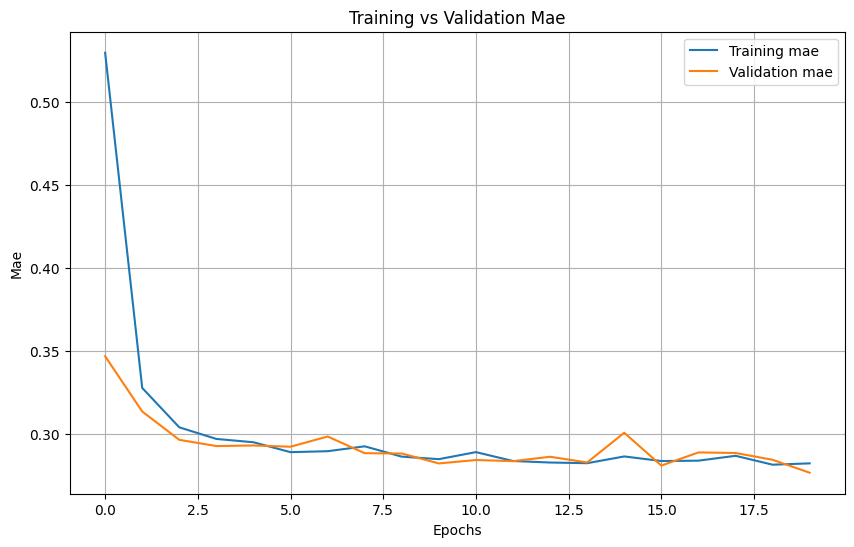

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Step 1: Load CSV
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Energy__kWh_'])
target = df['Energy__kWh_']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # shape = (time, rows=1, cols=n_features, channels=1)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build ConvLSTM → BiLSTM Model
def build_conv_bilstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False)(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_conv_bilstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Predict and Reshape Output
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)
y_true = y_test

# 11. Evaluation Metrics
def evaluate_model(y_true, y_pred, name="ConvLSTM-BiLSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance (7-Day Forecast):")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_true, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='blue')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


ConvBiLSTM-LSTM encoder decoder

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 1.7449 - mae: 0.6743 - val_loss: 0.8429 - val_mae: 0.4403
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.7169 - mae: 0.3929 - val_loss: 0.4451 - val_mae: 0.3365
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.4305 - mae: 0.3352 - val_loss: 0.3339 - val_mae: 0.3105
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.3185 - mae: 0.2967 - val_loss: 0.2833 - val_mae: 0.2952
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2756 - mae: 0.2877 - val_loss: 0.2499 - val_mae: 0.2879
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.2518 - mae: 0.2878 - val_loss: 0.2409 - val_mae: 0.3010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.2428 - mae: 0.2936 - val_loss: 0.2188 - val_mae: 0.2908
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2201 - mae: 0.2857 - val_loss: 0.2080 - val_mae: 0.2926
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.215

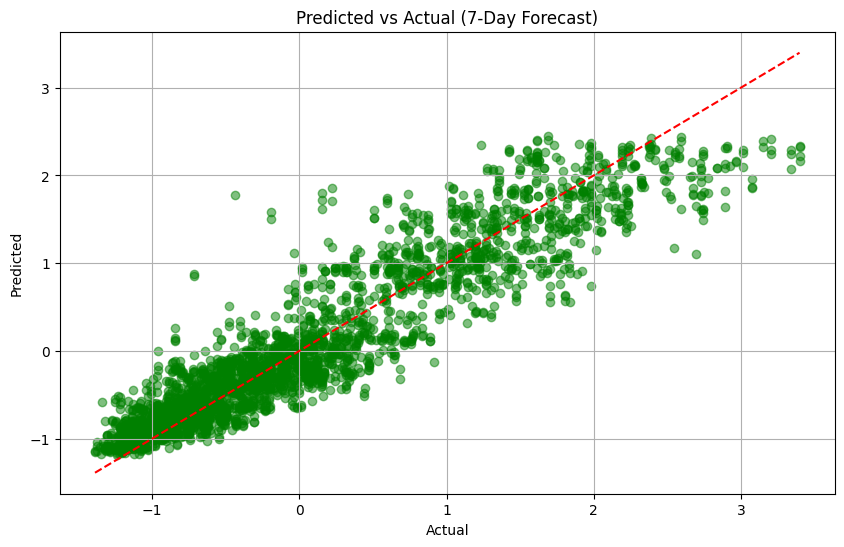

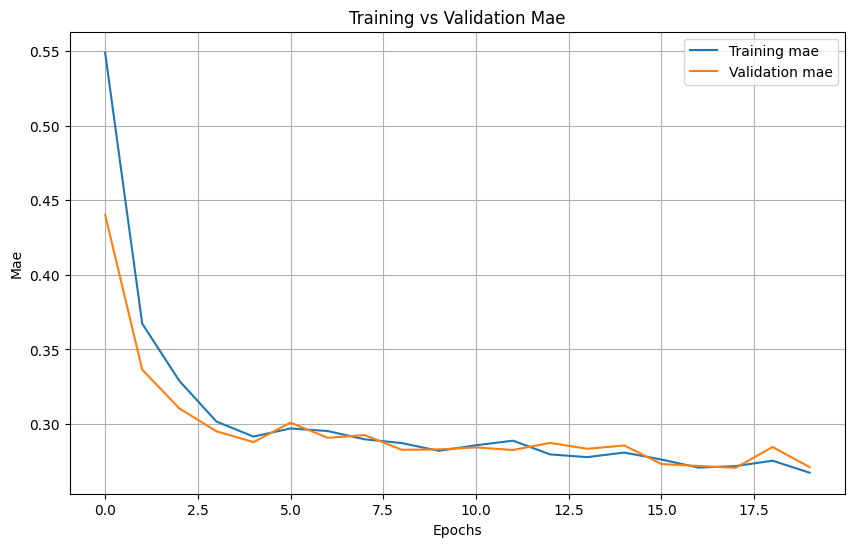

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Step 1: Load CSV
df = pd.read_csv("Boulder_Resampled_Daily_withSeaWeekend.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Energy__kWh_'])
target = df['Energy__kWh_']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # (t, rows, cols, ch)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build BiConvLSTM → LSTM Model
def build_biconvlstm_lstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False))(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_biconvlstm_lstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Prediction
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)

# 11. Evaluation
def evaluate_model(y_true, y_pred, name="BiConvLSTM-LSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_test, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='green')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


C:\Users\user\AppData\Local\Temp\ipykernel_25132\2087998903.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.rename(columns={'Total_Duration_hours': 'Total_time', 'Charging_Time_hours': 'Charge_time', 'Energy__kWh_': 'Energy'}, inplace=True)


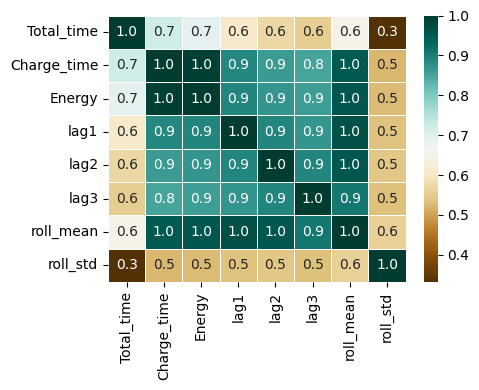

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Boulder_Resampled_Daily_withSeaWeekend.csv')

# Ensure the data is sorted by date if necessary
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')

# Create lag features
df['lag1'] = df['Energy__kWh_'].shift(1)
df['lag2'] = df['Energy__kWh_'].shift(2)
df['lag3'] = df['Energy__kWh_'].shift(3)

# Create rolling features (window=3, center=False)
df['roll_mean'] = df['Energy__kWh_'].rolling(window=3).mean()
df['roll_std'] = df['Energy__kWh_'].rolling(window=3).std()

# Select relevant columns
selected_columns = [
    'Total_Duration_hours', 'Charging_Time_hours', 'Energy__kWh_',
    'lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std'
]
selected_df = df[selected_columns]
selected_df.rename(columns={'Total_Duration_hours': 'Total_time', 'Charging_Time_hours': 'Charge_time', 'Energy__kWh_': 'Energy'}, inplace=True)

# Drop rows with NaN from lag/rolling calculation
selected_df = selected_df.dropna()

# Compute correlation matrix
correlation_matrix = selected_df.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='BrBG', linewidths=0.5)
#plt.title('Correlation Heatmap: Boulder')
plt.tight_layout()
plt.show()
